# 手書き数字認識(MNIST)

>**References **
>- https://qiita.com/phyblas/items/375ab130e53b0d04f784  
>- ゼロから作るディープラーニング  



---
## ①MNISTデータセットの準備  

1. [mnistのダウンロード](#sklearnを用いてmnistをダウンロード)
1. [描画関数](#描画)
1. [データの分割](#訓練用と検証用データに分割)

---

### sklearnを用いてmnistをダウンロード

In [1]:
import numpy as np
from sklearn import datasets
mnist = datasets.fetch_mldata('MNIST original',data_home=".")
X,T = mnist.data,mnist.target
x = X/255
t = np.zeros((int(len(T)),10)) # one hot label
for i in range(len(T)):
    t[i][ int(T[i]) ] = 1

print(X.shape)
print(t.shape)

(70000, 784)
(70000, 10)



### 描画

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


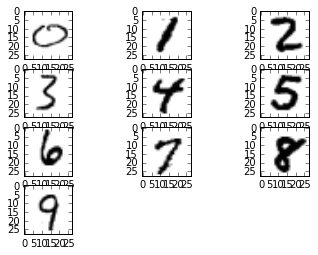

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_number(n):
    plt.imshow(X[n].reshape(28,28),cmap='gray_r')
    
for i in range(10):
    plt.subplot(4,3,i+1)
    plot_number(30+i*6500)
    print(t[30+i*6500])

### 訓練用と検証用データに分割

In [3]:
num_X = len(X)
rp = np.random.permutation(num_X)
thre = int( num_X * 1/7)

x_train, x_test = X[rp[thre:]], X[rp[:thre]]
t_train, t_test = t[rp[thre:]], t[rp[:thre]]

print(x_train.shape)
print(x_test.shape)
print(t_train.shape)
print(t_test.shape)

(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


--- 
## ②ニューラルネットワークの設計

1. [損失関数](#損失関数)
2. [ミニバッチ](#ミニバッチ対応)

---

### 損失関数

- ２乗和誤差

\begin{align}
E = \frac{1}{2}\sum_{k}(y_k - y_k^*)^2
\end{align}
$y_k : $  出力  
$y^*_k : $  正解データ

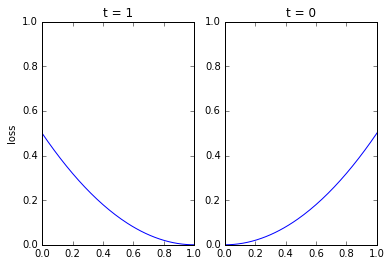

In [4]:
def mean_squared_error(y,t): # ２乗和誤差
    Error = 0.5 * (np.sum((y-t)**2))
    return Error

plt.subplot(121)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("t = 1")
plt.ylabel("loss")
x1 = np.arange(0,2,0.01)
y1 = [mean_squared_error(n,1) for n in x1]
plt.plot(x1,y1)

plt.subplot(122)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("t = 0")
x1 = np.arange(0,2,0.01)
y1 = [mean_squared_error(n,0) for n in x1]
plt.plot(x1,y1)

---
* 交差エントロピー

\begin{align}
E = - \sum_k y^*_k \log{y_k}
\end{align}

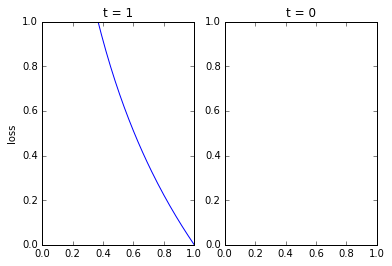

In [5]:
def cross_entropy_error(y,t):
    delta = 1e-7
    Error = -np.sum( t*np.log(y+delta))
    return Error

plt.subplot(121)
plt.title("t = 1")
plt.ylabel("loss")
plt.xlim(0,1)
plt.ylim(0,1)
x1 = np.arange(0,2,0.01)
y1 = [cross_entropy_error(n,1) for n in x1]
plt.plot(x1,y1)

plt.subplot(122)
plt.title("t = 0")
plt.xlim(0,1)
plt.ylim(0,1)
x1 = np.arange(0,2,0.01)
y1 = [cross_entropy_error(n,0) for n in x1]
plt.plot(x1,y1)

In [6]:
# sample
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
print(mean_squared_error(y,t))
print(cross_entropy_error(y,t))

0.0975
0.510825457099


### ミニバッチ対応

In [7]:
def loss_function(y,t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return cross_entropy_error(y,t) / batch_size

### 数値微分

\begin{align}
\frac{df(x)}{dx} = \lim_{h→0} \frac{f(x+h) - f(x)}{h}
\end{align}

ここでは、誤差を減らすため中央差分を用いる
\begin{align}
\frac{df(x)}{dx} = \lim_{h→0} \frac{f(x+h) - f(x-h)}{2h}
\end{align}


In [8]:
def numerical_diff(f,x):
    h = 1e-4
    return ( f(x+h) - f(x-h) ) / (2*h)

### 勾配法

In [9]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    for idx in range(len(x)):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)
        x[idx] = tmp_val - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    return grad

### 活性化関数
* シグモイド関数
\begin{align}
h(x) = \frac{1}{1+\exp(-x)}
\end{align}

In [10]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))

* ステップ関数

In [11]:
def step_function(x):
    return np.array(x > 0, dtype=np.int)

### 出力層
* ソフトマックス関数

In [12]:
def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

## ③学習

### ２層のニューラルネットワークを構築する


In [13]:
import sys, os
sys.path.append(os.pardir)

In [14]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads


 ### 学習

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


train acc, test acc | 0.0977166666667, 0.1013
train acc, test acc | 0.0977166666667, 0.1013
train acc, test acc | 0.099, 0.1018
train acc, test acc | 0.0974, 0.098
train acc, test acc | 0.0997833333333, 0.1003
train acc, test acc | 0.0974, 0.098
train acc, test acc | 0.11275, 0.1112
train acc, test acc | 0.102366666667, 0.0999
train acc, test acc | 0.0977166666667, 0.1013
train acc, test acc | 0.0978833333333, 0.0952
train acc, test acc | 0.0974, 0.098
train acc, test acc | 0.0906333333333, 0.0875
train acc, test acc | 0.0987833333333, 0.0976
train acc, test acc | 0.0987833333333, 0.0976
train acc, test acc | 0.102366666667, 0.0999
train acc, test acc | 0.0977166666667, 0.1013
train acc, test acc | 0.0974, 0.098


ValueError: x and y must have same first dimension

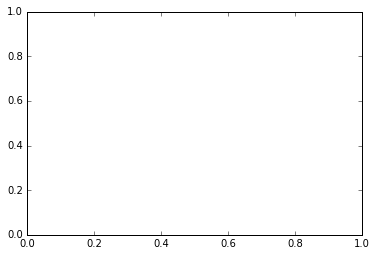

In [15]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

# ハイパーパラメータ
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) # 高速版 !
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

x1 = np.arange(0,len(train_acc_list))
plt.plot(x1, train_loss_list)
plt.plot(x1, train_acc_list)
plt.plot(x1, test_acc_list)
plt.show()